In [1]:
import sys
import time

import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import pandas as pd
from IPython.display import HTML

sys.path.append("code/.")

import mglearn
from IPython.display import display
from plotting_functions import *

# Classifiers and regressors
from sklearn.dummy import DummyClassifier, DummyRegressor

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer

# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from utils import *

pd.set_option("display.max_colwidth", 200)

# Lecture 5: Preprocessing and sklearn pipelines

UBC 2023-24

Instructor: Varada Kolhatkar and Andrew Roth

### Announcements
- HW1 grades have been posted.
- Homework 1 solutions have been posted on Canvas under Files tab. Please do not share them with anyone or do not post them anywhere. 
- No homework pull requests, please.

### Lecture plan

- Leftover iClicker questions from Lecture 5
- Motivation for preprocessing
- Class demo + break 

### Warmup 

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

- (A) $k$-NN may perform poorly in high-dimensional space (say, *d* > 1000). 
- (B) In SVM RBF, removing a non-support vector would not change the decision boundary. 
- (C) In sklearn’s SVC classifier, large values of gamma tend to result in higher training score but probably lower validation score. 
- (D) If we increase both gamma and C, we can't be certain if the model becomes more complex or less complex.

### Learning outcomes

From this lecture, you will be able to 

- Explain motivation for preprocessing in supervised machine learning;
- Identify when to implement feature transformations such as imputation, scaling, and one-hot encoding in a machine learning model development pipeline; 
- Use `sklearn` transformers for applying feature transformations on your dataset;
- Discuss golden rule in the context of feature transformations;
- Use `sklearn.pipeline.Pipeline` and `sklearn.pipeline.make_pipeline` to build a preliminary machine learning pipeline. 

### Motivation
- So far we have seen
    - Three ML models (decision trees, $k$-NNs, SVMs with RBF kernel)
    - ML fundamentals (train-validation-test split, cross-validation, the fundamental tradeoff, the golden rule)
- Are we ready to do machine learning on real-world datasets?
    - Very often real-world datasets need preprocessing before we use them to build ML models.

In [2]:
spotify_df = pd.read_csv("data/spotify.csv", index_col=0)
spotify_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [3]:
two_songs = spotify_df.sample(2, random_state=42)
two_songs[["duration_ms", "tempo"]]

,duration_ms,tempo
1555,341667,107.327
526,386907,143.948


In [4]:
euclidean_distances(two_songs[["duration_ms", "tempo"]])

array([[    0.        , 45240.01482203],
       [45240.01482203,     0.        ]])

- The distance is completely dominated by the the features with larger values
- The features with smaller values are being ignored. 
- Does it matter? 
    - Yes! Scale is based on how data was collected. 
    - Features on a smaller scale can be highly informative and there is no good reason to ignore them.
    - We want our model to be robust and not sensitive to the scale. 
- Is this a problem for decision trees?

In [5]:
two_songs[["duration_ms", "tempo"]]

,duration_ms,tempo
1555,341667,107.327
526,386907,143.948


### `fit` and `transform` paradigm for transformers
- `sklearn` uses `fit` and `transform` paradigms for feature transformations. 
- We `fit` the transformer on the train split and then transform the train split as well as the test split. 
- We apply the same transformations on the test split. 

### `sklearn` API summary: estimators

Suppose `model` is a classification or regression model. 

```
model.fit(X_train, y_train)
X_train_predictions = model.predict(X_train)
X_test_predictions = model.predict(X_test)
```   

### `sklearn` API summary: transformers

Suppose `transformer` is a transformer used to change the input representation, for example, to tackle missing values or to scales numeric features.

```
transformer.fit(X_train, [y_train])
X_train_transformed = transformer.transform(X_train)
X_test_transformed = transformer.transform(X_test)
```  

In [6]:
spotify_df = pd.read_csv("data/spotify.csv", index_col=0)
train_df, test_df = train_test_split(spotify_df, test_size=0.20, random_state=123)
X_train, y_train = (
    train_df.drop(columns=["song_title", "artist", "target"]),
    train_df["target"],
)
X_test, y_test = (
    test_df.drop(columns=["song_title", "artist", "target"]),
    test_df["target"],
)

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  # create feature trasformer object
scaler.fit(X_train)  # fitting the transformer on the train split
X_train_scaled = scaler.transform(X_train)  # transforming the train split
X_test_scaled = scaler.transform(X_test)  # transforming the test split

In [8]:
knn_unscaled = KNeighborsClassifier()
knn_unscaled.fit(X_train, y_train)
print("Train score: %0.3f" % (knn_unscaled.score(X_train, y_train)))
print("Test score: %0.3f" % (knn_unscaled.score(X_test, y_test)))

Train score: 0.726
Test score: 0.552


In [9]:
knn_scaled = KNeighborsClassifier()
knn_scaled.fit(X_train_scaled, y_train)
print("Train score: %0.3f" % (knn_scaled.score(X_train_scaled, y_train)))
print("Test score: %0.3f" % (knn_scaled.score(X_test_scaled, y_test)))

Train score: 0.798
Test score: 0.686


### Common preprocessing techniques

Some commonly performed feature transformation include:  
- Imputation: Tackling missing values
- Scaling: Scaling of numeric features
- One-hot encoding: Tackling categorical variables      
    

We can have one lecture on each of them! In this lesson our goal is to getting familiar with them so that we can use them to build ML pipelines. 

## Imputation and scaling

In [10]:
housing_df = pd.read_csv("data/housing.csv")
train_df, test_df = train_test_split(housing_df, test_size=0.1, random_state=123)
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN


In [11]:
train_df = train_df.assign(
    rooms_per_household=train_df["total_rooms"] / train_df["households"]
)
test_df = test_df.assign(
    rooms_per_household=test_df["total_rooms"] / test_df["households"]
)

train_df = train_df.assign(
    bedrooms_per_household=train_df["total_bedrooms"] / train_df["households"]
)
test_df = test_df.assign(
    bedrooms_per_household=test_df["total_bedrooms"] / test_df["households"]
)

train_df = train_df.assign(
    population_per_household=train_df["population"] / train_df["households"]
)
test_df = test_df.assign(
    population_per_household=test_df["population"] / test_df["households"]
)

In [12]:
train_df = train_df.drop(columns = ['population', 'total_rooms', 'total_bedrooms'])
test_df =  test_df.drop(columns = ['population', 'total_rooms', 'total_bedrooms'])

In [13]:
X_train = train_df.drop(columns=["median_house_value", "ocean_proximity"])
y_train = train_df["median_house_value"]

X_test = test_df.drop(columns=["median_house_value", "ocean_proximity"])
y_test = test_df["median_house_value"]

### What transformations do we need to apply on the dataset? 

- Some missing values in `total_bedrooms` column
- Scales are quite different across columns. 
- Categorical variable `ocean_proximity`

### Imputation
- The $k$-nn classifier is not able to deal with missing values (NaNs).
- What are possible ways to deal with the problem? 
    - Delete the rows? 
    - Replace them with some reasonable values?    

  - `SimpleImputer` is a transformer in `sklearn` to deal with this problem. For example, 
    - You can impute missing values in categorical columns with the most frequent value.
    - You can impute the missing values in numeric columns with the mean or median of the column.  

In [14]:
imputer = SimpleImputer(strategy="median")
imputer.fit(X_train)
X_train_imp = imputer.transform(X_train)
X_test_imp = imputer.transform(X_test)

### Scaling
- This problem affects a large number of ML methods.
- A number of approaches to this problem. We are going to look into two most popular ones.  

| Approach | What it does | How to update $X$ (but see below!) | sklearn implementation | 
|---------|------------|-----------------------|----------------|
| standardization | sets sample mean to $0$, s.d. to $1$   | `X -= np.mean(X,axis=0)`<br>`X /=  np.std(X,axis=0)` | [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) |

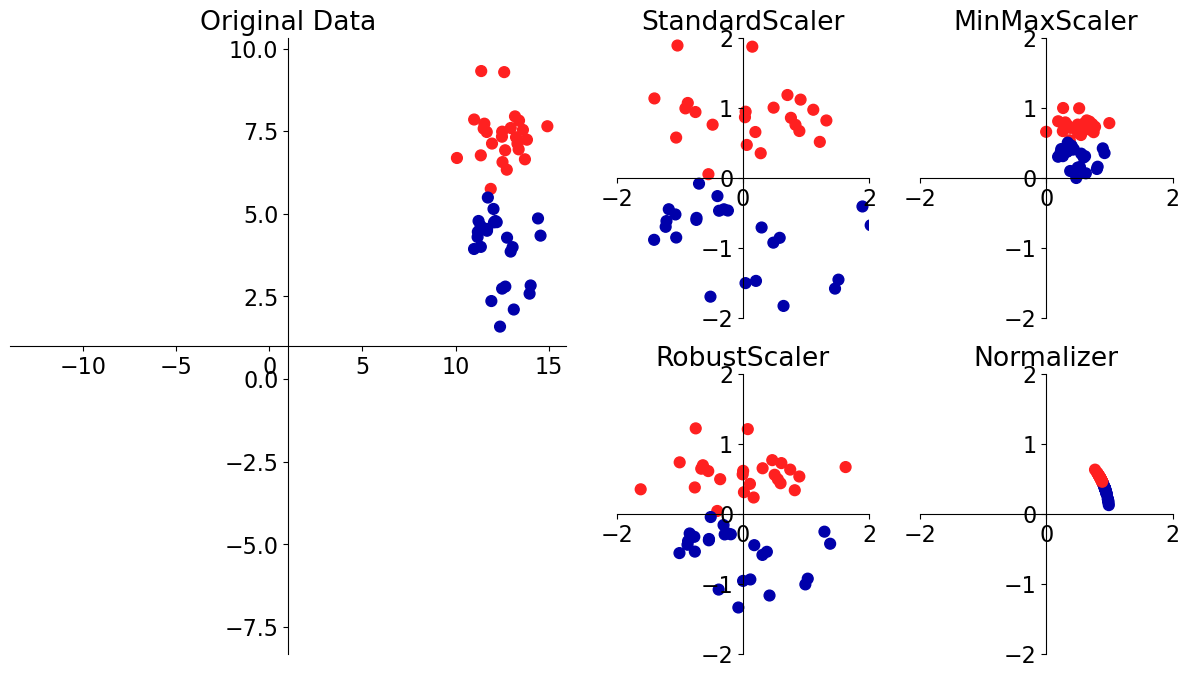

In [15]:
mglearn.plots.plot_scaling()

In [16]:
from sklearn.preprocessing import StandardScaler
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)
pd.DataFrame(X_train_scaled, columns=X_train.columns)

,longitude,latitude,housing_median_age,households,median_income,rooms_per_household,bedrooms_per_household,population_per_household
0,0.908140,-0.743917,-0.526078,0.266135,-0.389736,-0.210591,-0.083813,0.126398
1,-0.002057,1.083123,-0.923283,-1.253312,-0.198924,4.726412,11.166631,-0.050132
2,1.218207,-1.352930,1.380504,0.542873,-0.635239,-0.273606,-0.025391,-0.099240
3,1.128188,-0.753286,-0.843842,-0.561467,0.714077,0.122307,-0.280310,0.010183
4,1.168196,-1.287344,-0.843842,2.500924,-1.059242,-0.640266,-0.190617,0.126808
...,...,...,...,...,...,...,...,...
18571,0.733102,-0.804818,0.586095,-0.966131,-0.118182,0.063110,-0.099558,0.071541
18572,1.163195,-1.057793,-1.161606,0.728235,0.357500,0.235096,-0.163397,0.007458
18573,-1.097293,0.797355,-1.876574,0.514155,0.934269,0.211892,-0.135305,0.044029
18574,-1.437367,1.008167,1.221622,-0.454427,0.006578,-0.273382,-0.149822,-0.132875


In [17]:
knn = KNeighborsRegressor()
knn.fit(X_train_imp, y_train)
knn.score(X_train_imp, y_train)

0.5609808539232339

In [18]:
knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)
knn.score(X_train_scaled, y_train)

0.7978563117812038

### (iClicker) Exercise 5.1 

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

- A. `StandardScaler` ensures a fixed range (i.e., minimum and maximum values) for the features. 
- B. `StandardScaler` calculates mean and standard deviation for each feature separately. 
- C. In general, it's a good idea to apply scaling on numeric features before training $k$-NN or SVM RBF models. 
- D. The transformed feature values might be hard to interpret for humans.
- E. After applying `SimpleImputer` the transformed data has a different shape than the original data.  

## Feature transformations and the golden rule

### How to carry out cross-validation? 

- Last week we saw that cross validation is a better way to get a realistic assessment of the model. 
- Let's try cross-validation with transformed data. 

In [19]:
knn = KNeighborsRegressor()
scaler = StandardScaler()
scaler.fit(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)
scores = cross_validate(knn, X_train_scaled, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.012694,0.192978,0.696373,0.794236
1,0.012614,0.171257,0.684447,0.791467
2,0.012479,0.191378,0.695532,0.789436
3,0.011844,0.181551,0.679478,0.793243
4,0.012002,0.111255,0.680657,0.794820


- Do you see any problem here? 
- Are we applying `fit_transform` on train portion and `transform` on validation portion in each fold?  
    - Here you might be allowing information from the validation set to **leak** into the training step.

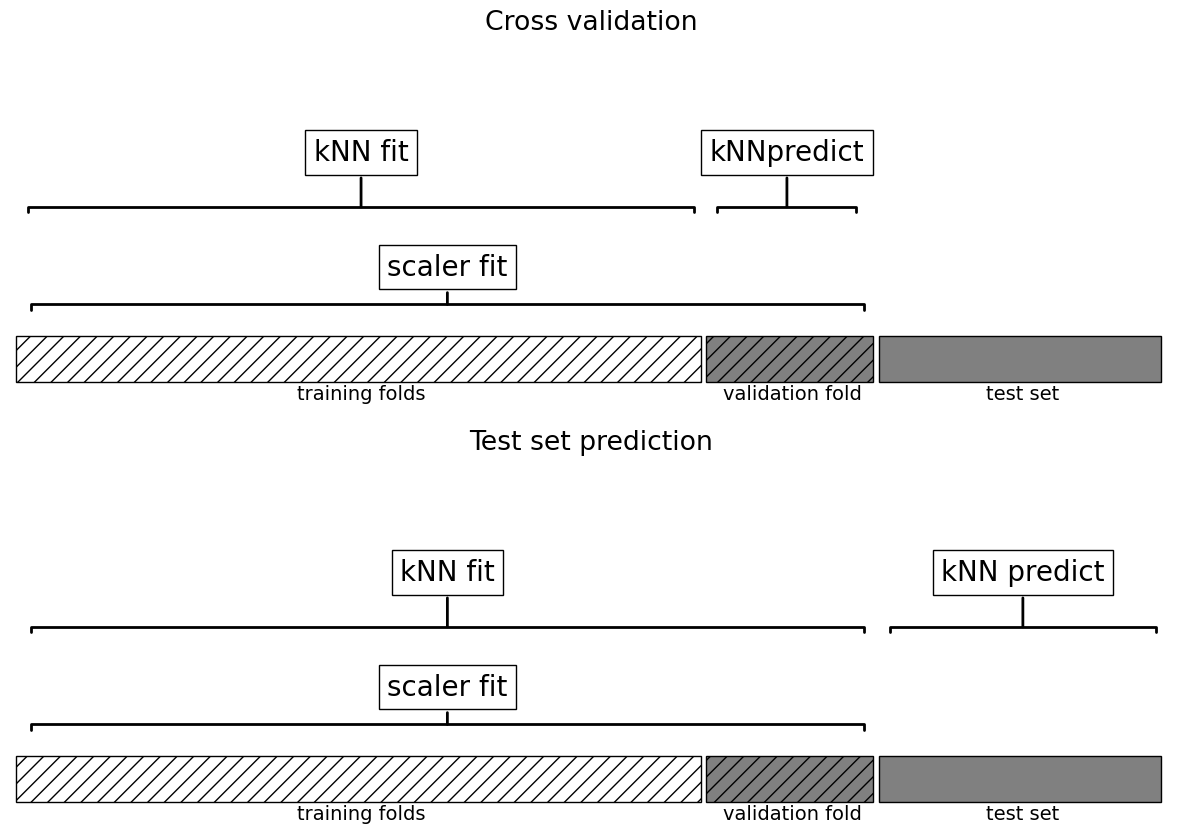

In [20]:
plot_improper_processing("kNN")

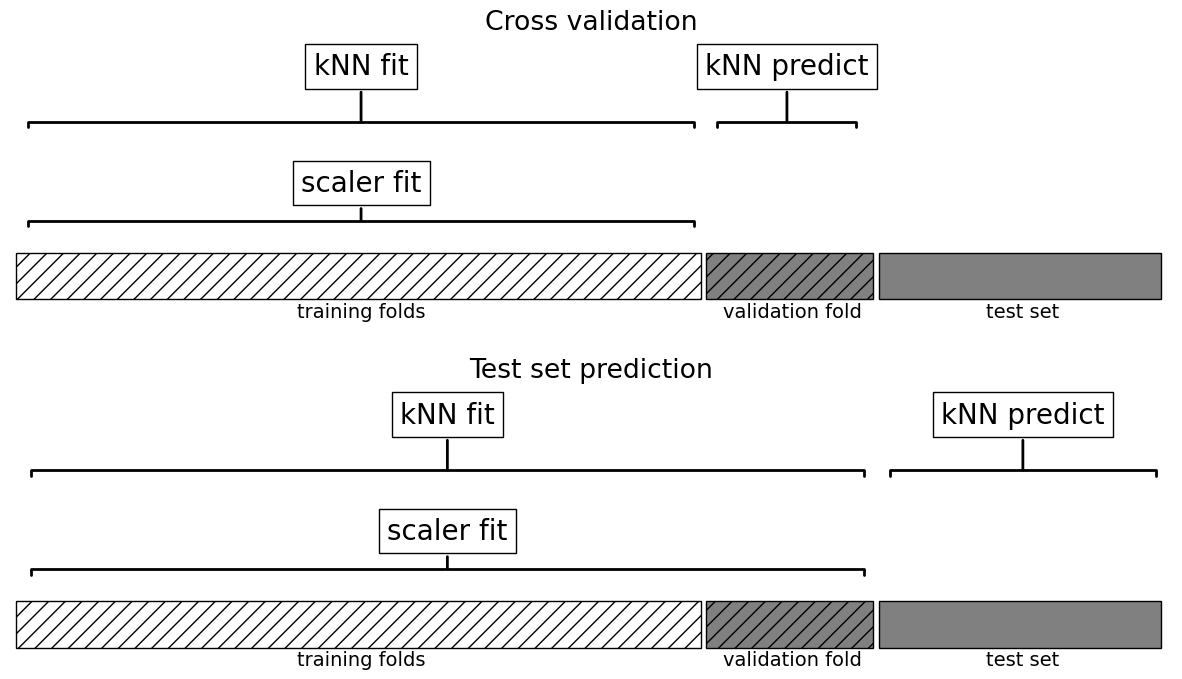

In [21]:
plot_proper_processing("kNN")

- You need to apply the **SAME** preprocessing steps to train/validation.
- With many different transformations and cross validation the code gets unwieldy very quickly. 
- Likely to make mistakes and "leak" information

### Pipelines
- You need to apply the **SAME** preprocessing steps to train/validation.
- With many different transformations and cross validation the code gets unwieldy very quickly. 
- Likely to make mistakes and "leak" information

Can we do this in a more elegant and organized way?

- YES!! Using [`scikit-learn Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).
- [`scikit-learn Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) allows you to define a "pipeline" of transformers with a final estimator.

In [22]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("regressor", KNeighborsRegressor()),
    ]
)

In [23]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('regressor', KNeighborsRegressor())])

When you call `fit` on the pipeline, it carries out the following steps:

- Fit `SimpleImputer` on `X_train`
- Transform `X_train` using the fit `SimpleImputer` to create `X_train_imp`
- Fit `StandardScaler` on `X_train_imp`
- Transform `X_train_imp` using the fit `StandardScaler` to create `X_train_imp_scaled`
- Fit the model (`KNeighborsRegressor` in our case) on `X_train_imp_scaled`

![](img/pipeline.png)
<!-- <img src='./img/pipeline.png' width="800"> -->
    
[Source](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#18)

## Categorical features
- In `scikit-learn`, most algorithms require numeric inputs.
- Decision trees could theoretically work with categorical features.  
    - However, the sklearn implementation does not support this. 

### What are the options? 

- Drop the column (not recommended)
    - If you know that the column is not relevant to the target in any way you may drop it. 
- We can transform categorical features to numeric ones so that we can use them in the model.     
    - [Ordinal encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) (occasionally recommended)
    - One-hot encoding (recommended in most cases) (this lecture)

In [24]:
X_toy = pd.DataFrame(
    {
        "language": [
            "English",
            "Vietnamese",
            "English",
            "Mandarin",
            "English",
            "English",
            "Mandarin",
            "English",
            "Vietnamese",
            "Mandarin",
            "French",
            "Spanish",
            "Mandarin",
            "Hindi",
        ]
    }
)
X_toy

,language
0,English
1,Vietnamese
2,English
3,Mandarin
4,English
5,English
6,Mandarin
7,English
8,Vietnamese
9,Mandarin


### Ordinal encoding (occasionally recommended)

- Here we simply assign an integer to each of our unique categorical labels. 
- We can use sklearn's [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

In [25]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
enc.fit(X_toy)
X_toy_ord = enc.transform(X_toy)
df = pd.DataFrame(
    data=X_toy_ord,
    columns=["language_enc"],
    index=X_toy.index,
)
pd.concat([X_toy, df], axis=1)

,language,language_enc
0,English,0.0
1,Vietnamese,5.0
2,English,0.0
3,Mandarin,3.0
4,English,0.0
5,English,0.0
6,Mandarin,3.0
7,English,0.0
8,Vietnamese,5.0
9,Mandarin,3.0


#### One-hot encoding (OHE)
- Create new binary columns to represent our categories.
- If we have $c$ categories in our column.
    - We create $c$ new binary columns to represent those categories.
- Example: Imagine a language column which has the information on whether you 

- We can use sklearn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to do so.

In [26]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
enc.fit(X_toy)
X_toy_ohe = enc.transform(X_toy)
pd.DataFrame(
    data=X_toy_ohe,
    columns=enc.get_feature_names_out(["language"]),
    index=X_toy.index,
)

,language_English,language_French,language_Hindi,language_Mandarin,language_Spanish,language_Vietnamese
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,0.0,0.0,1.0,0.0,0.0


### (iClicker) Exercise 5.2

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

- A. You can have scaling of numeric features, one-hot encoding of categorical features, and `scikit-learn` estimator within a single pipeline.  
- B. Once you have a `scikit-learn` pipeline object with an estimator as the last step, you can call `fit`, `predict`, and `score` on it.
- C. You can carry out data splitting within `scikit-learn` pipeline. 
- D. We have to be careful of the order we put each transformation and model in a pipeline.
- E. If you call `cross_validate` with a pipeline object, it will call `fit` and `transform` on the training fold and only `transform` on the validation fold. 